# Load data

In [1]:
from kubetools import get_all, delete, top, get_gcloud_node_info
from subprocess import check_output
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re 
sns.set(font_scale=1.5, style='white')
%matplotlib inline

In [2]:
# Grab all pods + pod resources information, merge into one df
df_top = top('pod')
df_get = get_all('pod')
df = pd.merge(df_top, df_get, on='name', how='outer')

# Convert age to hours and sort
df['age'] /= 60.0
df = df.sort_values(['age', 'cpu'], ascending=False)

# Determine if this is a user/prod/etc pod
df['kind'] = df['name'].map(lambda a: a.split('-')[0])

df['restarts'] = pd.to_numeric(df['restarts'])

# Grab node information from both kubectl and gcloud
nodes = get_all('node')
nodes_gcloud = get_gcloud_node_info().rename(columns={'external_ip': 'external-ip', 'status': 'status_gcloud'})
nodes = pd.merge(nodes, nodes_gcloud, on=['name', 'external-ip'])
nodes = nodes[['name', 'internal_ip', 'external-ip', 'status', 'roles', 'age', 'version', 'os-image',
               'kernel-version', 'container-runtime', 'zone', 'machine_type', 'status_gcloud']]

# Sandbox

In [3]:
df.groupby('node').count()['name']

node
4tsn    34
5mpp    48
qvdt    32
Name: name, dtype: int64

# Specific queries

## Pods per node

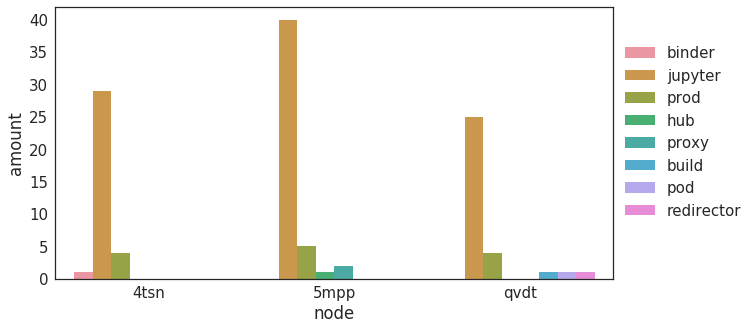

In [4]:
# All pods
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='node', y='amount', hue='kind',
            data=df.groupby(['node', 'kind']).count()['name'].reset_index(name='amount'))
ax.legend(loc=(1.01, .2))

In [5]:
df.groupby(['node', 'fullnode']).count()['name'].sort_values()

node  fullnode                            
qvdt  gke-prod-a-ssd-pool-32-134a959a-qvdt    32
4tsn  gke-prod-a-ssd-pool-32-134a959a-4tsn    34
5mpp  gke-prod-a-ssd-pool-32-134a959a-5mpp    48
Name: name, dtype: int64

## Pod statuses

In [6]:
df.groupby(['status', 'node']).count()['name']

status           node
Completed        5mpp    12
PodInitializing  4tsn     1
Running          4tsn    33
                 5mpp    36
                 qvdt    32
Name: name, dtype: int64

## Production pods by node

In [7]:
names = ['hub-', 'binder-', 'pod-culler-', 'redirector-', 'prod-']
df.loc[[not ii.startswith('jupyter-') for ii in df['name'].values]].sort_values(['node', 'name']).set_index(['node', 'kind'])

name    cpu  \
node kind                                                                   
4tsn binder                                binder-5b8b4479cb-ffc88   55.0   
     prod                                          prod-dind-p8x64    3.0   
     prod                          prod-kube-lego-7c8df7d844-8966z    0.0   
     prod           prod-nginx-ingress-controller-7b4fdbdcc8-gw5ql   17.0   
     prod                      prod-prometheus-node-exporter-gmvrr    0.0   
5mpp hub                                      hub-6cfd8bf669-qmls8  100.0   
     prod                                          prod-dind-c8jp5    3.0   
     prod                            prod-grafana-55fc87c88d-v84cp    0.0   
     prod        prod-nginx-ingress-default-backend-5f864798db-...    0.0   
     prod        prod-prometheus-kube-state-metrics-7596599c6f-...    2.0   
     prod                      prod-prometheus-node-exporter-nzdj9    0.0   
     proxy                                  proxy-54f5f7cf7b-64ks9   79.0   
     proxy                          proxy-patches-6548cd8f44-wxmkw    4.0   
qvdt build       build-rafaelbidese-2dfvc-2dpractice-3fae6c-5c1b29    NaN   
     pod                                pod-culler-96bb965fd-vbjzq    5.0   
     prod                                          prod-dind-cq96r  477.0   
     prod           prod-nginx-ingress-controller-7b4fdbdcc8-r2g64   32.0   
     prod                      prod-prometheus-node-exporter-5hhp2    1.0   
     prod                   prod-prometheus-server-54f5849b6-4r2gb   66.0   
     redirector                        redirector-5dddb6597c-khp5c    0.0   

                 memory ready   status  restarts        age            ip  \
node kind                                                                   
4tsn binder       0.418   1/1  Running         0  17.000000  10.12.38.183   
     prod        51.626   1/1  Running         0  18.000000    10.12.38.2   
     prod         0.014   1/1  Running         0  17.000000  10.12.38.186   
     prod         0.478   2/2  Running         0  17.000000  10.12.38.184   
     prod         0.023   1/1  Running         0  18.000000    10.128.0.3   
5mpp hub          0.136   1/1  Running         3  24.000000  10.12.37.111   
     prod         5.086   1/1  Running         2  24.000000  10.12.37.122   
     prod         0.035   1/1  Running         2  17.000000  10.12.37.132   
     prod         0.009   1/1  Running         2  24.000000  10.12.37.131   
     prod         0.036   1/1  Running         2  17.000000  10.12.37.123   
     prod         0.021   1/1  Running         2  24.000000    10.128.0.2   
     proxy        1.261   2/2  Running         4  24.000000  10.12.37.121   
     proxy        0.025   2/2  Running         7  24.000000  10.12.37.110   
qvdt build          NaN   1/1  Running         0   0.016667  10.12.34.211   
     pod          0.049   1/1  Running         7  17.000000  10.12.34.161   
     prod         8.239   1/1  Running         0  72.000000    10.12.34.3   
     prod         0.537   2/2  Running         0  24.000000  10.12.34.216   
     prod         0.029   1/1  Running         0  72.000000    10.128.0.4   
     prod         3.166   2/2  Running         0  72.000000  10.12.34.173   
     redirector   0.007   1/1  Running         0  72.000000  10.12.34.171   

                                             fullnode  
node kind                                              
4tsn binder      gke-prod-a-ssd-pool-32-134a959a-4tsn  
     prod        gke-prod-a-ssd-pool-32-134a959a-4tsn  
     prod        gke-prod-a-ssd-pool-32-134a959a-4tsn  
     prod        gke-prod-a-ssd-pool-32-134a959a-4tsn  
     prod        gke-prod-a-ssd-pool-32-134a959a-4tsn  
5mpp hub         gke-prod-a-ssd-pool-32-134a959a-5mpp  
     prod        gke-prod-a-ssd-pool-32-134a959a-5mpp  
     prod        gke-prod-a-ssd-pool-32-134a959a-5mpp  
     prod        gke-prod-a-ssd-pool-32-134a959a-5mpp  
     prod        gke-prod-a-ssd-pool-32-134a959a-5mpp  


## Pod restarts

In [8]:
df.sort_values('restarts', ascending=False).head(10)

,name,cpu,memory,ready,status,restarts,age,ip,node,fullnode,kind
25,pod-culler-96bb965fd-vbjzq,5.0,0.049,1/1,Running,7,17.000000,10.12.34.161,qvdt,gke-prod-a-ssd-pool-32-134a959a-qvdt,pod
26,proxy-patches-6548cd8f44-wxmkw,4.0,0.025,2/2,Running,7,24.000000,10.12.37.110,5mpp,gke-prod-a-ssd-pool-32-134a959a-5mpp,proxy
9,proxy-54f5f7cf7b-64ks9,79.0,1.261,2/2,Running,4,24.000000,10.12.37.121,5mpp,gke-prod-a-ssd-pool-32-134a959a-5mpp,proxy
8,hub-6cfd8bf669-qmls8,100.0,0.136,1/1,Running,3,24.000000,10.12.37.111,5mpp,gke-prod-a-ssd-pool-32-134a959a-5mpp,hub
59,prod-grafana-55fc87c88d-v84cp,0.0,0.035,1/1,Running,2,17.000000,10.12.37.132,5mpp,gke-prod-a-ssd-pool-32-134a959a-5mpp,prod
29,prod-dind-c8jp5,3.0,5.086,1/1,Running,2,24.000000,10.12.37.122,5mpp,gke-prod-a-ssd-pool-32-134a959a-5mpp,prod
34,prod-prometheus-kube-state-metrics-7596599c6f-...,2.0,0.036,1/1,Running,2,17.000000,10.12.37.123,5mpp,gke-prod-a-ssd-pool-32-134a959a-5mpp,prod
54,prod-prometheus-node-exporter-nzdj9,0.0,0.021,1/1,Running,2,24.000000,10.128.0.2,5mpp,gke-prod-a-ssd-pool-32-134a959a-5mpp,prod
61,prod-nginx-ingress-default-backend-5f864798db-...,0.0,0.009,1/1,Running,2,24.000000,10.12.37.131,5mpp,gke-prod-a-ssd-pool-32-134a959a-5mpp,prod
84,jupyter-ipython-2dipython-2din-2ddepth-2dk3x31imx,0.0,0.059,1/1,Running,0,0.216667,10.12.37.144,5mpp,gke-prod-a-ssd-pool-32-134a959a-5mpp,jupyter


## Pod Resources

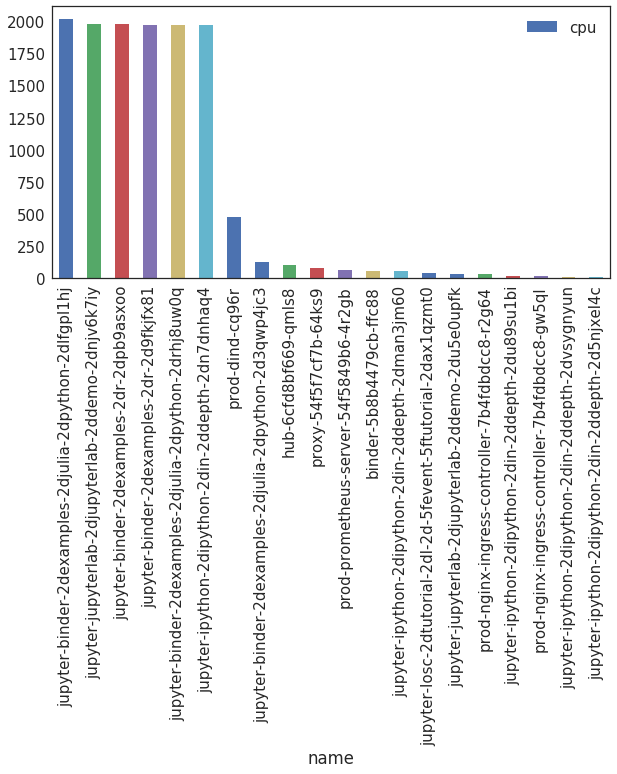

In [9]:
# CPU usage
df.sort_values('cpu', ascending=False).head(20).plot.bar(x='name', y='cpu', figsize=(10, 5))

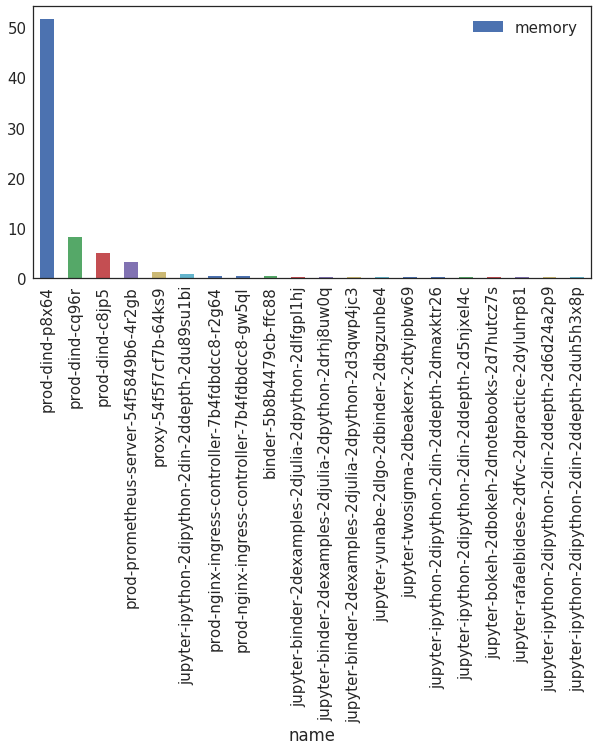

In [10]:
df.sort_values('memory', ascending=False).head(20).plot.bar(x='name', y='memory', figsize=(10, 5))

## Distribution of pod age

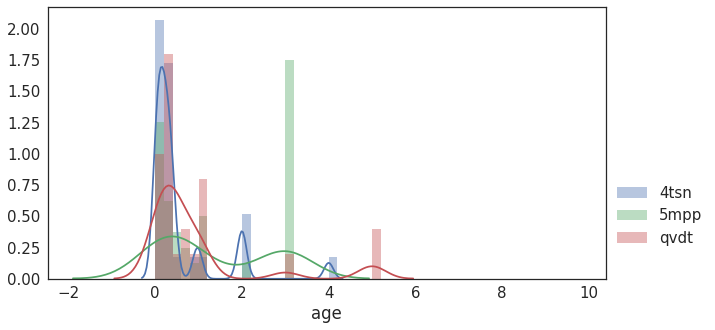

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

for node, vals in df.groupby('node'):
    sns.distplot(vals.query('kind=="jupyter"')['age'], bins=np.arange(0, 10, .2),
                 kde=True, ax=ax, label=node)
ax.legend(loc=(1.01, .1))

## Nodes

In [ ]:
nodes.sort_values('internal_ip')